In [ ]:
 #Source: https://towardsdatascience.com/downloading-historical-stock-prices-in-python-93f85f059c1f

!pip install yfinance
!pip install giotto-tda
!pip install gudhi

from gtda.homology import VietorisRipsPersistence
import gtda.time_series
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
from scipy import stats
import gtda.diagrams
import pandas as pd
import numpy as np
import math
import yfinance as yf
import datetime
import time
import requests
import io
import sys
import gudhi.wasserstein
import gudhi.hera
import gudhi

  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 28.1MB 150kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT


In [ ]:
def get_data(Symbols = ['^GSPC','^DJI','^IXIC','^RUT'], start = datetime.datetime(1987,12,22), end = datetime.datetime(2016,12,8)):
  stock_final = pd.DataFrame()
  # iterate over each symbol
  for i in Symbols:  
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
  return stock_final

In [ ]:
#gspc_1 = stock_final[stock_final['Name'] == '^GSPC'].index
#gspc = stock_final[stock_final['Name'] == '^GSPC']['Close']
def get_adjusted_prices(stock_data):
  adj_prices = []
  for i in range(1,np.shape(stock_data)[0]):
    adj_prices.append(math.log(stock_data[i]/stock_data[i-1]))
  return stats.zscore(adj_prices)

In [ ]:
def embedding_taken(data, delay, dimension):
  embed_data = []
  for i in range(0, len(data)-delay*dimension+1):
    t = []
    for j in range(0,dimension):
      t.append(data[i+j*delay])
    embed_data.append(t)
  return embed_data

In [ ]:
def segment_cloud(pcd, size = 75, step = 50):
  start = []
  stop = []
  max = np.shape(np.array(pcd))[0]
  for i in range(0, max, step):
    start.append(i)
    stop.append(i+size)
  return start, stop

In [ ]:
def get_plot_data(pcd, size = 75, step = 50, vector = 'wdist'):
  start, stop = segment_cloud(pcd, size, step)
  return_data = []
  if vector == 'wdist':
    wasserstein_distance = []
    for i in range(0,len(start)):
      points = pcd[start[i]:stop[i]]
      shape = np.shape(points)
      pointcloud = np.array(points).reshape(1,shape[0],shape[1])
      VR = VietorisRipsPersistence() 
      diagrams = VR.fit_transform(pointcloud)
      wasserstein_distance.append(gtda.diagrams.Amplitude(metric ='wasserstein', order = None).fit_transform(diagrams))
    return_data = wasserstein_distance 
  elif vector == 'ent':
    for i in range(0,len(start)):
      points = pcd[start[i]:stop[i]]
      shape = np.shape(points)
      pointcloud = np.array(points).reshape(1,shape[0],shape[1])
      VR = VietorisRipsPersistence() 
      diagrams = VR.fit_transform(pointcloud)
      return_data.append(gtda.diagrams.PersistenceEntropy().fit_transform(diagrams))
  elif vector == 'land':
    for i in range(0,len(start)):
      points = pcd[start[i]:stop[i]]
      shape = np.shape(points)
      pointcloud = np.array(points).reshape(1,shape[0],shape[1])
      VR = VietorisRipsPersistence() 
      diagrams = VR.fit_transform(pointcloud)
      return_data.append(gtda.diagrams.Amplitude(metric_params={"n_layers":250} , metric ='landscape', order = None).fit_transform(diagrams))
  elif vector == 'wdist_2':
    for i in range(0,len(start)-1):
      points = pcd[start[i]:stop[i]]
      points_1 = pcd[start[i+1]:stop[i+1]]
      shape = np.shape(points)
      pointcloud = np.array(points).reshape(1,shape[0],shape[1])
      shape_1 = np.shape(points_1)
      pointcloud_1 = np.array(points_1).reshape(1,shape_1[0],shape_1[1])
      VR = VietorisRipsPersistence(homology_dimensions = [1]) 
      diagrams = (VR.fit_transform(pointcloud))[0][:,0:2]
      diagrams_1 = (VR.fit_transform(pointcloud_1))[0][:,0:2]
      k = gudhi.hera.wasserstein_distance(diagrams, diagrams_1)
      VR = VietorisRipsPersistence(homology_dimensions = [0])
      diagrams = (VR.fit_transform(pointcloud))[0][:,0:2]
      diagrams_1 = (VR.fit_transform(pointcloud_1))[0][:,0:2]
      h = gudhi.hera.wasserstein_distance(diagrams, diagrams_1)
      return_data.append([h,k])
  elif vector == 'bneck':
    for i in range(0,len(start)-1):
      points = pcd[start[i]:stop[i]]
      points_1 = pcd[start[i+1]:stop[i+1]]
      shape = np.shape(points)
      pointcloud = np.array(points).reshape(1,shape[0],shape[1])
      shape_1 = np.shape(points_1)
      pointcloud_1 = np.array(points_1).reshape(1,shape_1[0],shape_1[1])
      VR = VietorisRipsPersistence(homology_dimensions = [1]) 
      diagrams = (VR.fit_transform(pointcloud))[0][:,0:2]
      diagrams_1 = (VR.fit_transform(pointcloud_1))[0][:,0:2]
      k = gudhi.hera.bottleneck_distance(diagrams, diagrams_1)
      VR = VietorisRipsPersistence(homology_dimensions = [0])
      diagrams = (VR.fit_transform(pointcloud))[0][:,0:2]
      diagrams_1 = (VR.fit_transform(pointcloud_1))[0][:,0:2]
      h = gudhi.hera.bottleneck_distance(diagrams, diagrams_1)
      return_data.append([h,k])
  return return_data

In [ ]:
def get_peak_data(plot_data, ar = [], ty = "peak", no = 10):
  length = len(plot_data)
  if ar == []:
    ar = np.arange(0,length)
  ord_0 = np.argsort(plot_data)
  ord_1 = np.argsort(-plot_data)
  if ty == "peak":
    return ord_1[:no]
  elif ty == "dips":
    return ord_1[:no]
  else:
    return None

In [ ]:
stock_final = get_data()
adj_prices = get_adjusted_prices(stock_final[stock_final['Name'] == '^GSPC']['Close'])
embedding_g = embedding_taken(adj_prices, delay = 1, dimension = 11)
adj_prices = get_adjusted_prices(stock_final[stock_final['Name'] == '^RUT']['Close'])
embedding_r = embedding_taken(adj_prices, delay = 1, dimension = 11)
adj_prices = get_adjusted_prices(stock_final[stock_final['Name'] == '^IXIC']['Close'])
embedding_i = embedding_taken(adj_prices, delay = 1, dimension = 11)
start, stop = segment_cloud(embedding_g, size = 75, step = 50)
order = pd.DataFrame()

0 : ^GSPC,1 : ^DJI,2 : ^IXIC,3 : ^RUT,

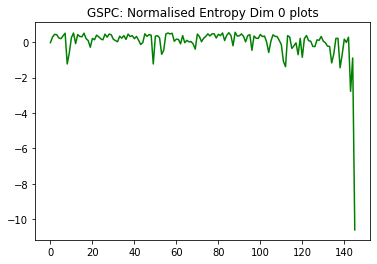

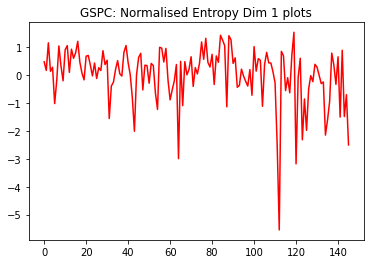

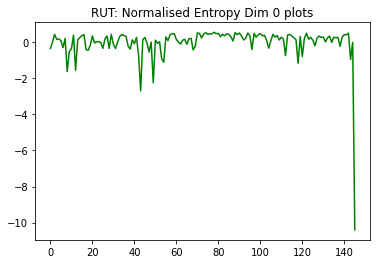

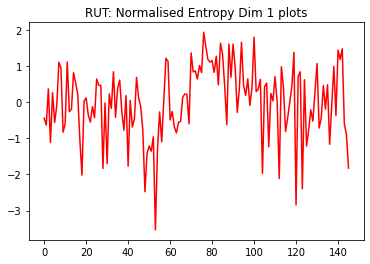

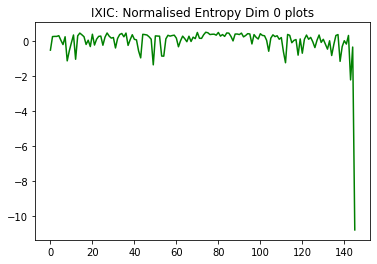

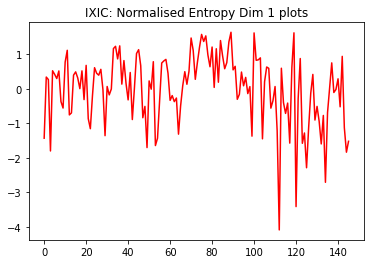

In [ ]:
plot_data = get_plot_data(embedding_g, vector = 'ent')
dim0 = np.array(plot_data).reshape((len(start),2))[:,0]
dim1 = np.array(plot_data).reshape((len(start),2))[:,1]

order['GSPC_Peak_Ent_0'] = get_peak_data(dim0, ty = "peak")
order['GSPC_Dips_Ent_0'] = get_peak_data(dim0, ty = "dips")
order['GSPC_Peak_Ent_1'] = get_peak_data(dim1, ty = "peak")
order['GSPC_Dips_Ent_1'] = get_peak_data(dim1, ty = "dips")

plt.title("GSPC: Normalised Entropy Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(0,146), y_1, color ="green")  
plt.show()

plt.title("GSPC: Normalised Entropy Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(0,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_r, vector = 'ent')
dim0 = np.array(plot_data).reshape((len(start),2))[:,0]
dim1 = np.array(plot_data).reshape((len(start),2))[:,1]

order['RUT_Peak_Ent_0'] = get_peak_data(dim0, ty = "peak")
order['RUT_Dips_Ent_0'] = get_peak_data(dim0, ty = "dips")
order['RUT_Peak_Ent_1'] = get_peak_data(dim1, ty = "peak")
order['RUT_Dips_Ent_1'] = get_peak_data(dim1, ty = "dips")

plt.title("RUT: Normalised Entropy Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(0,146), y_1, color ="green")  
plt.show()

plt.title("RUT: Normalised Entropy Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(0,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_i, vector = 'ent')
dim0 = np.array(plot_data).reshape((len(start),2))[:,0]
dim1 = np.array(plot_data).reshape((len(start),2))[:,1]

order['IXIC_Peak_Ent_0'] = get_peak_data(dim0, ty = "peak")
order['IXIC_Dips_Ent_0'] = get_peak_data(dim0, ty = "dips")
order['IXIC_Peak_Ent_1'] = get_peak_data(dim1, ty = "peak")
order['IXIC_Dips_Ent_1'] = get_peak_data(dim1, ty = "dips")

plt.title("IXIC: Normalised Entropy Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(0,146), y_1, color ="green")  
plt.show()

plt.title("IXIC: Normalised Entropy Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(0,146), y_1, color ="red")  
plt.show()

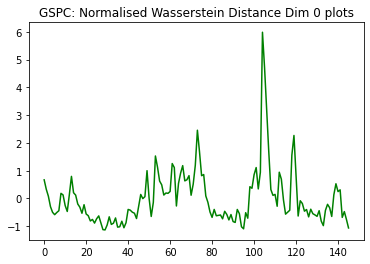

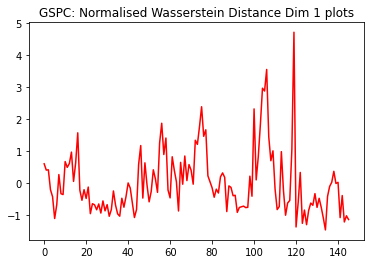

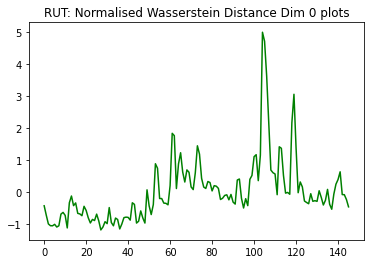

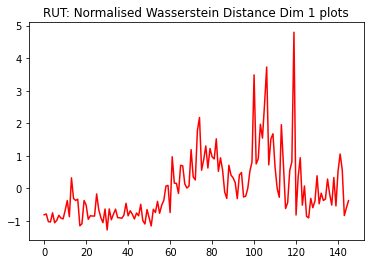

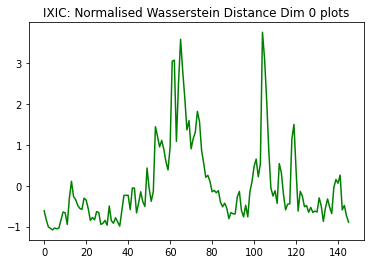

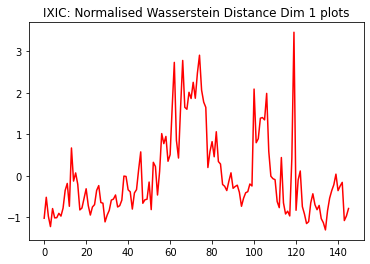

In [ ]:
plot_data = get_plot_data(embedding_g, vector = 'wdist')
dim0 = np.array(plot_data).reshape((len(start),2))[:,0]
dim1 = np.array(plot_data).reshape((len(start),2))[:,1]

order['GSPC_Peak_wd_0'] = get_peak_data(dim0, ty = "peak")
order['GSPC_Dips_wd_0'] = get_peak_data(dim0, ty = "dips")
order['GSPC_Peak_wd_1'] = get_peak_data(dim1, ty = "peak")
order['GSPC_Dips_wd_1'] = get_peak_data(dim1, ty = "dips")

plt.title("GSPC: Normalised Wasserstein Distance Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(0,146), y_1, color ="green")  
plt.show()

plt.title("GSPC: Normalised Wasserstein Distance Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(0,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_r, vector = 'wdist')
dim0 = np.array(plot_data).reshape((len(start),2))[:,0]
dim1 = np.array(plot_data).reshape((len(start),2))[:,1]

order['RUT_Peak_wd_0'] = get_peak_data(dim0, ty = "peak")
order['RUT_Dips_wd_0'] = get_peak_data(dim0, ty = "dips")
order['RUT_Peak_wd_1'] = get_peak_data(dim1, ty = "peak")
order['RUT_Dips_wd_1'] = get_peak_data(dim1, ty = "dips")

plt.title("RUT: Normalised Wasserstein Distance Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(0,146), y_1, color ="green")  
plt.show()

plt.title("RUT: Normalised Wasserstein Distance Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(0,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_i, vector = 'wdist')
dim0 = np.array(plot_data).reshape((len(start),2))[:,0]
dim1 = np.array(plot_data).reshape((len(start),2))[:,1]

order['IXIC_Peak_wd_0'] = get_peak_data(dim0, ty = "peak")
order['IXIC_Dips_wd_0'] = get_peak_data(dim0, ty = "dips")
order['IXIC_Peak_wd_1'] = get_peak_data(dim1, ty = "peak")
order['IXIC_Dips_wd_1'] = get_peak_data(dim1, ty = "dips")

plt.title("IXIC: Normalised Wasserstein Distance Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(0,146), y_1, color ="green")  
plt.show()

plt.title("IXIC: Normalised Wasserstein Distance Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(0,146), y_1, color ="red")  
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


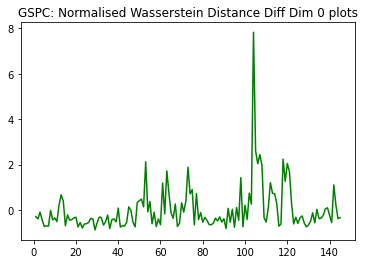

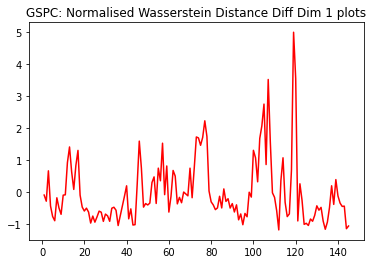

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


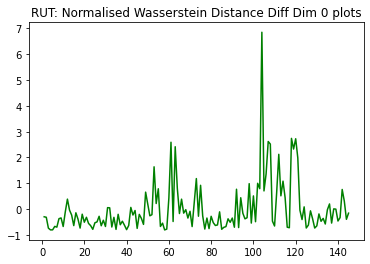

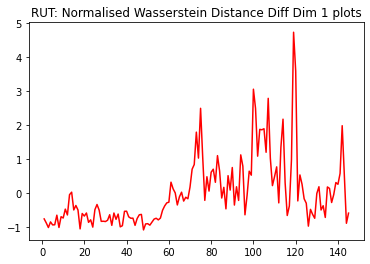

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


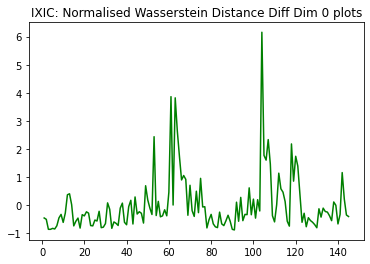

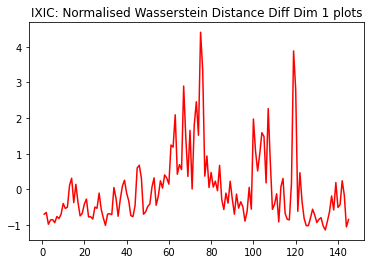

In [ ]:
plot_data = get_plot_data(embedding_g, vector = 'wdist_2')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['GSPC_Peak_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "peak")
order['GSPC_Dips_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "dips")
order['GSPC_Peak_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "peak")
order['GSPC_Dips_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "dips")

plt.title("GSPC: Normalised Wasserstein Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,146), y_1, color ="green")  
plt.show()

plt.title("GSPC: Normalised Wasserstein Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_r, vector = 'wdist_2')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['RUT_Peak_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "peak")
order['RUT_Dips_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "dips")
order['RUT_Peak_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "peak")
order['RUT_Dips_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "dips")

plt.title("RUT: Normalised Wasserstein Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,146), y_1, color ="green")  
plt.show()

plt.title("RUT: Normalised Wasserstein Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_i, vector = 'wdist_2')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['IXIC_Peak_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "peak")
order['IXIC_Dips_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "dips")
order['IXIC_Peak_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "peak")
order['IXIC_Dips_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "dips")

plt.title("IXIC: Normalised Wasserstein Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,146), y_1, color ="green")  
plt.show()

plt.title("IXIC: Normalised Wasserstein Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,146), y_1, color ="red")  
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


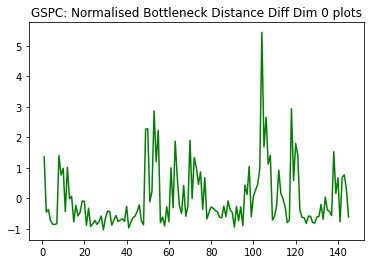

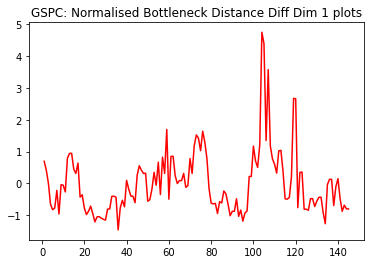

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


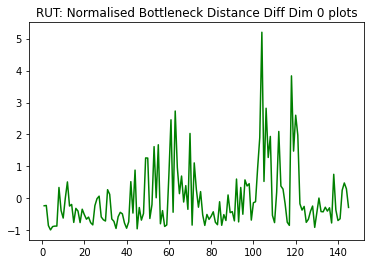

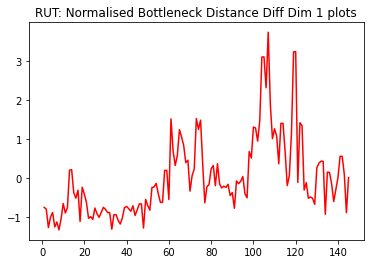

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


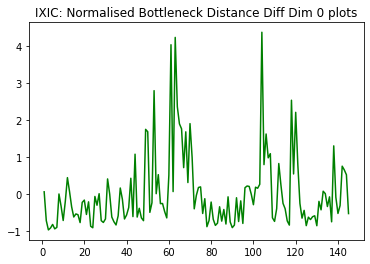

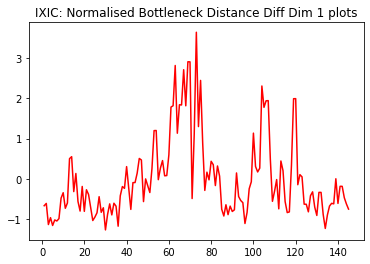

In [ ]:
plot_data = get_plot_data(embedding_g, vector = 'bneck')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['GSPC_Peak_bn_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "peak")
order['GSPC_Dips_bn_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "dips")
order['GSPC_Peak_bn_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "peak")
order['GSPC_Dips_bn_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "dips")

plt.title("GSPC: Normalised Bottleneck Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,146), y_1, color ="green")  
plt.show()

plt.title("GSPC: Normalised Bottleneck Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_r, vector = 'bneck')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['RUT_Peak_bn_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "peak")
order['RUT_Dips_bn_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "dips")
order['RUT_Peak_bn_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "peak")
order['RUT_Dips_bn_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "dips")

plt.title("RUT: Normalised Bottleneck Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,146), y_1, color ="green")  
plt.show()

plt.title("RUT: Normalised Bottleneck Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,146), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_i, vector = 'bneck')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['IXIC_Peak_bn_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "peak")
order['IXIC_Dips_bn_0'] = get_peak_data(dim0, ar = np.arange(1,146), ty = "dips")
order['IXIC_Peak_bn_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "peak")
order['IXIC_Dips_bn_1'] = get_peak_data(dim1, ar = np.arange(1,146), ty = "dips")

plt.title("IXIC: Normalised Bottleneck Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,146), y_1, color ="green")  
plt.show()

plt.title("IXIC: Normalised Bottleneck Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,146), y_1, color ="red")  
plt.show()

In [ ]:
order.head()
order.to_csv("order.csv")
! mv "order.csv" "/content/drive/My Drive"

In [ ]:
#PointCloud Peak Dates
peaks = pd.DataFrame()
tooltips = []
tooltip_s = np.array(stock_final[stock_final['Name'] == '^GSPC'].index)
for i in range(0,len(tooltip_s)):
  tooltips.append(str(tooltip_s[i].astype('datetime64[D]')))

peaks['GSPC_wd2_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_wd2_0'])]]
peaks['GSPC_wd2_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_wd2_0'])]]
peaks['GSPC_wd2_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_wd2_1'])]]
peaks['GSPC_wd2_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_wd2_1'])]]
peaks['RUT_wd2_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_wd2_0'])]]
peaks['RUT_wd2_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_wd2_0'])]]
peaks['RUT_wd2_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_wd2_1'])]]
peaks['RUT_wd2_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_wd2_1'])]]
peaks['IXIC_wd2_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_wd2_0'])]]
peaks['IXIC_wd2_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_wd2_0'])]]
peaks['IXIC_wd2_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_wd2_1'])]]
peaks['IXIC_wd2_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_wd2_1'])]]

peaks['GSPC_bn_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_bn_0'])]]
peaks['GSPC_bn_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_bn_0'])]]
peaks['GSPC_bn_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_bn_1'])]]
peaks['GSPC_bn_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_bn_1'])]]
peaks['RUT_bn_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_bn_0'])]]
peaks['RUT_bn_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_bn_0'])]]
peaks['RUT_bn_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_bn_1'])]]
peaks['RUT_bn_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_bn_1'])]]
peaks['IXIC_bn_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_bn_0'])]]
peaks['IXIC_bn_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_bn_0'])]]
peaks['IXIC_bn_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_bn_1'])]]
peaks['IXIC_bn_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_bn_1'])]]


In [ ]:
peaks

,GSPC_wd2_0_start,GSPC_wd2_0_stop,GSPC_wd2_1_start,GSPC_wd2_1_stop,RUT_wd2_0_start,RUT_wd2_0_stop,RUT_wd2_1_start,RUT_wd2_1_stop,IXIC_wd2_0_start,IXIC_wd2_0_stop,IXIC_wd2_1_start,IXIC_wd2_1_stop,GSPC_bn_0_start,GSPC_bn_0_stop,GSPC_bn_1_start,GSPC_bn_1_stop,RUT_bn_0_start,RUT_bn_0_stop,RUT_bn_1_start,RUT_bn_1_stop,IXIC_bn_0_start,IXIC_bn_0_stop,IXIC_bn_1_start,IXIC_bn_1_stop
0,2008-05-27,2008-09-11,2011-05-17,2011-09-01,2008-05-27,2008-09-11,2011-05-17,2011-09-01,2008-05-27,2008-09-11,2002-08-21,2002-12-06,2008-05-27,2008-09-11,2008-05-27,2008-09-11,2008-05-27,2008-09-11,2008-12-29,2009-04-17,2008-05-27,2008-09-11,2002-04-01,2002-07-17
1,2008-08-06,2008-11-20,2011-07-28,2011-11-11,2011-03-07,2011-06-22,2011-07-28,2011-11-11,1999-11-04,2000-02-23,2011-05-17,2011-09-01,2011-03-07,2011-06-22,2008-08-06,2008-11-20,2011-03-07,2011-06-22,2011-07-28,2011-11-11,2000-03-29,2000-07-17,2001-06-07,2001-09-28
2,2008-12-29,2009-04-17,2008-12-29,2009-04-17,2011-07-28,2011-11-11,2007-08-09,2007-11-26,2000-03-29,2000-07-17,2002-10-31,2003-02-20,1998-04-06,1998-07-23,2008-12-29,2009-04-17,2008-10-16,2009-02-04,2011-05-17,2011-09-01,1999-11-04,2000-02-23,2001-08-17,2001-12-10
3,2011-03-07,2011-06-22,2008-08-06,2008-11-20,2008-12-29,2009-04-17,2008-12-29,2009-04-17,2000-06-09,2000-09-26,2001-01-12,2001-05-02,2008-10-16,2009-02-04,2011-05-17,2011-09-01,2000-03-29,2000-07-17,2008-08-06,2008-11-20,1998-04-06,1998-07-23,2000-03-29,2000-07-17
4,1998-04-06,1998-07-23,2003-01-14,2003-05-02,1999-11-04,2000-02-23,2002-08-21,2002-12-06,1998-04-06,1998-07-23,2011-07-28,2011-11-11,1997-08-29,1997-12-16,2011-07-28,2011-11-11,2011-07-28,2011-11-11,2008-05-27,2008-09-11,2011-03-07,2011-06-22,2001-01-12,2001-05-02
5,2011-07-28,2011-11-11,2008-05-27,2008-09-11,2009-03-12,2009-06-29,2007-10-19,2008-02-07,2008-12-29,2009-04-17,2002-04-01,2002-07-17,1997-06-19,1997-10-06,1999-06-15,1999-09-30,1999-11-04,2000-02-23,2008-10-16,2009-02-04,2000-06-09,2000-09-26,2002-08-21,2002-12-06
6,2008-10-16,2009-02-04,2003-03-27,2003-07-15,2000-03-29,2000-07-17,2010-05-20,2010-09-07,2011-03-07,2011-06-22,2008-12-29,2009-04-17,1998-08-27,1998-12-14,2002-10-31,2003-02-20,2009-12-24,2010-04-15,2009-03-12,2009-06-29,2011-07-28,2011-11-11,2008-05-27,2008-09-11
7,2009-03-12,2009-06-29,2002-04-01,2002-07-17,2011-05-17,2011-09-01,2015-12-10,2016-03-31,2008-08-06,2008-11-20,2000-03-29,2000-07-17,2001-08-17,2001-12-10,2002-04-01,2002-07-17,2001-08-17,2001-12-10,2002-04-01,2002-07-17,2001-08-17,2001-12-10,2011-07-28,2011-11-11
8,2002-04-01,2002-07-17,2002-10-31,2003-02-20,2009-12-24,2010-04-15,2008-08-06,2008-11-20,2011-07-28,2011-11-11,2007-08-09,2007-11-26,2000-03-29,2000-07-17,2002-06-11,2002-09-26,2011-10-07,2012-01-26,1999-11-04,2000-02-23,2000-08-21,2000-12-06,2011-05-17,2011-09-01
9,2000-03-29,2000-07-17,2002-06-11,2002-09-26,2011-10-07,2012-01-26,2008-03-14,2008-07-01,2000-08-21,2000-12-06,2002-01-16,2002-05-06,2011-07-28,2011-11-11,2008-10-16,2009-02-04,2009-03-12,2009-06-29,2002-08-21,2002-12-06,2000-10-31,2001-02-20,2008-12-29,2009-04-17


In [ ]:
peaks.to_csv("peaks.csv")
!mv "peaks.csv" "/content/drive/My Drive"

Analysis around 2021

In [ ]:
stock_final = get_data(start = datetime.datetime(2000,12,22), end = datetime.datetime(2021,2,8))
adj_prices = get_adjusted_prices(stock_final[stock_final['Name'] == '^GSPC']['Close'])
embedding_g = embedding_taken(adj_prices, delay = 1, dimension = 11)
adj_prices = get_adjusted_prices(stock_final[stock_final['Name'] == '^RUT']['Close'])
embedding_r = embedding_taken(adj_prices, delay = 1, dimension = 11)
adj_prices = get_adjusted_prices(stock_final[stock_final['Name'] == '^IXIC']['Close'])
embedding_i = embedding_taken(adj_prices, delay = 1, dimension = 11)
start, stop = segment_cloud(embedding_g, size = 75, step = 50)
order = pd.DataFrame()

0 : ^GSPC,1 : ^DJI,2 : ^IXIC,3 : ^RUT,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


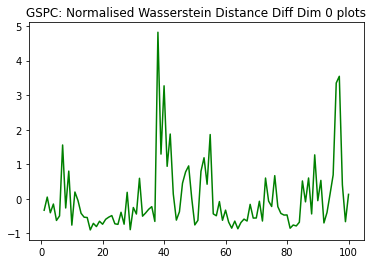

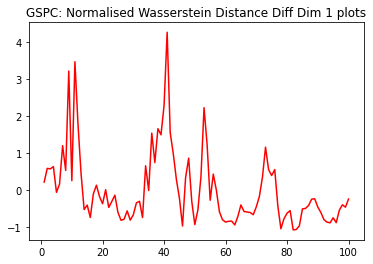

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


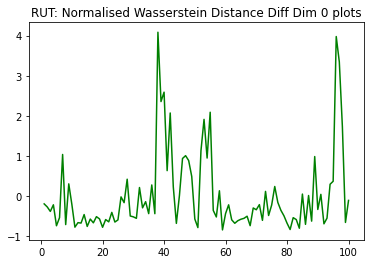

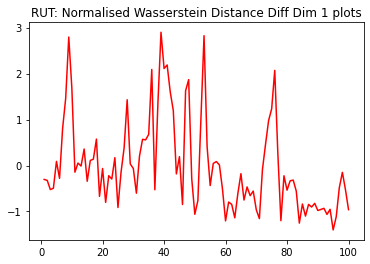

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


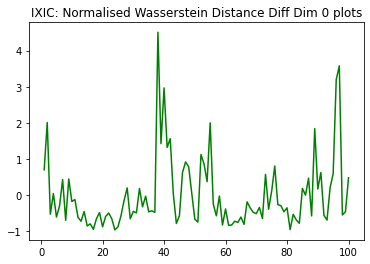

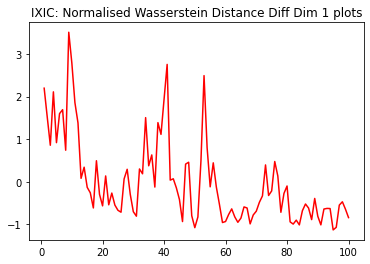

In [ ]:
k = len(start)
plot_data = get_plot_data(embedding_g, vector = 'wdist_2')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['GSPC_Peak_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "peak")
order['GSPC_Dips_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "dips")
order['GSPC_Peak_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "peak")
order['GSPC_Dips_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "dips")

plt.title("GSPC: Normalised Wasserstein Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,k), y_1, color ="green")  
plt.show()

plt.title("GSPC: Normalised Wasserstein Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,k), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_r, vector = 'wdist_2')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['RUT_Peak_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "peak")
order['RUT_Dips_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "dips")
order['RUT_Peak_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "peak")
order['RUT_Dips_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "dips")

plt.title("RUT: Normalised Wasserstein Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,k), y_1, color ="green")  
plt.show()

plt.title("RUT: Normalised Wasserstein Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,k), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_i, vector = 'wdist_2')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['IXIC_Peak_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "peak")
order['IXIC_Dips_wd2_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "dips")
order['IXIC_Peak_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "peak")
order['IXIC_Dips_wd2_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "dips")

plt.title("IXIC: Normalised Wasserstein Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,k), y_1, color ="green")  
plt.show()

plt.title("IXIC: Normalised Wasserstein Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,k), y_1, color ="red")  
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


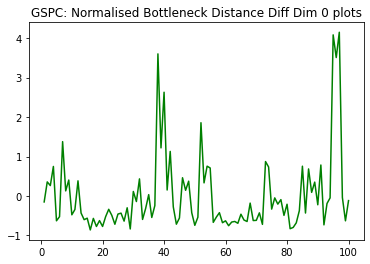

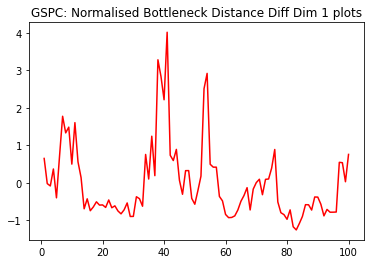

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


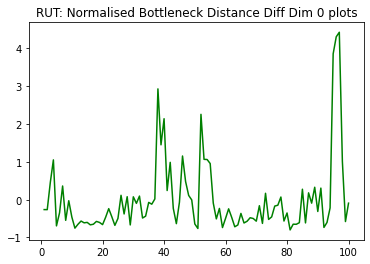

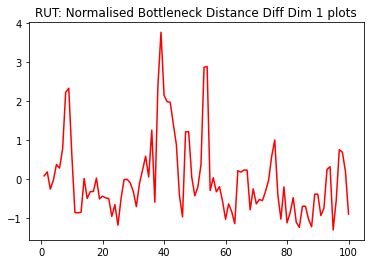

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


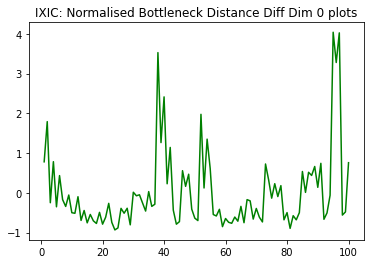

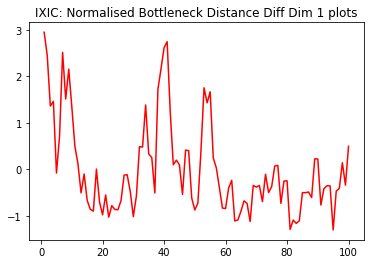

In [ ]:
k = len(start)
plot_data = get_plot_data(embedding_g, vector = 'bneck')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['GSPC_Peak_bn_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "peak")
order['GSPC_Dips_bn_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "dips")
order['GSPC_Peak_bn_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "peak")
order['GSPC_Dips_bn_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "dips")

plt.title("GSPC: Normalised Bottleneck Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,k), y_1, color ="green")  
plt.show()

plt.title("GSPC: Normalised Bottleneck Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,k), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_r, vector = 'bneck')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['RUT_Peak_bn_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "peak")
order['RUT_Dips_bn_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "dips")
order['RUT_Peak_bn_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "peak")
order['RUT_Dips_bn_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "dips")

plt.title("RUT: Normalised Bottleneck Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,k), y_1, color ="green")  
plt.show()

plt.title("RUT: Normalised Bottleneck Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,k), y_1, color ="red")  
plt.show()

plot_data = get_plot_data(embedding_i, vector = 'bneck')
dim0 = np.array(plot_data).reshape((len(start)-1,2))[:,0]
dim1 = np.array(plot_data).reshape((len(start)-1,2))[:,1]

order['IXIC_Peak_bn_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "peak")
order['IXIC_Dips_bn_0'] = get_peak_data(dim0, ar = np.arange(1,k), ty = "dips")
order['IXIC_Peak_bn_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "peak")
order['IXIC_Dips_bn_1'] = get_peak_data(dim1, ar = np.arange(1,k), ty = "dips")

plt.title("IXIC: Normalised Bottleneck Distance Diff Dim 0 plots") 
y_1 = stats.zscore(dim0)
#y_2 = dim0
plt.plot(np.arange(1,k), y_1, color ="green")  
plt.show()

plt.title("IXIC: Normalised Bottleneck Distance Diff Dim 1 plots") 
y_1 = stats.zscore(dim1)
#y_2 = dim1
plt.plot(np.arange(1,k), y_1, color ="red")  
plt.show()

In [ ]:
order.head()
order.to_csv("order_2.csv")
! mv "order_2.csv" "/content/drive/My Drive"

In [ ]:
peaks = pd.DataFrame()
tooltips = []
tooltip_s = np.array(stock_final[stock_final['Name'] == '^GSPC'].index)
for i in range(0,len(tooltip_s)):
  tooltips.append(str(tooltip_s[i].astype('datetime64[D]')))

peaks['GSPC_wd2_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_wd2_0'])]]
peaks['GSPC_wd2_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_wd2_0'])]]
peaks['GSPC_wd2_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_wd2_1'])]]
peaks['GSPC_wd2_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_wd2_1'])]]
peaks['RUT_wd2_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_wd2_0'])]]
peaks['RUT_wd2_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_wd2_0'])]]
peaks['RUT_wd2_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_wd2_1'])]]
peaks['RUT_wd2_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_wd2_1'])]]
peaks['IXIC_wd2_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_wd2_0'])]]
peaks['IXIC_wd2_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_wd2_0'])]]
peaks['IXIC_wd2_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_wd2_1'])]]
peaks['IXIC_wd2_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_wd2_1'])]]

peaks['GSPC_bn_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_bn_0'])]]
peaks['GSPC_bn_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_bn_0'])]]
peaks['GSPC_bn_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['GSPC_Peak_bn_1'])]]
peaks['GSPC_bn_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['GSPC_Peak_bn_1'])]]
peaks['RUT_bn_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_bn_0'])]]
peaks['RUT_bn_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_bn_0'])]]
peaks['RUT_bn_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['RUT_Peak_bn_1'])]]
peaks['RUT_bn_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['RUT_Peak_bn_1'])]]
peaks['IXIC_bn_0_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_bn_0'])]]
peaks['IXIC_bn_0_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_bn_0'])]]
peaks['IXIC_bn_1_start'] = np.array(tooltips)[np.array(start)[np.array(order['IXIC_Peak_bn_1'])]]
peaks['IXIC_bn_1_stop'] = np.array(tooltips)[np.array(stop)[np.array(order['IXIC_Peak_bn_1'])]]

In [ ]:
peaks

,GSPC_wd2_0_start,GSPC_wd2_0_stop,GSPC_wd2_1_start,GSPC_wd2_1_stop,RUT_wd2_0_start,RUT_wd2_0_stop,RUT_wd2_1_start,RUT_wd2_1_stop,IXIC_wd2_0_start,IXIC_wd2_0_stop,IXIC_wd2_1_start,IXIC_wd2_1_stop,GSPC_bn_0_start,GSPC_bn_0_stop,GSPC_bn_1_start,GSPC_bn_1_stop,RUT_bn_0_start,RUT_bn_0_stop,RUT_bn_1_start,RUT_bn_1_stop,IXIC_bn_0_start,IXIC_bn_0_stop,IXIC_bn_1_start,IXIC_bn_1_stop
0,2008-05-07,2008-08-22,2008-12-09,2009-03-30,2008-05-07,2008-08-22,2008-07-18,2008-11-03,2008-05-07,2008-08-22,2002-08-02,2002-11-18,2020-01-27,2020-05-13,2008-12-09,2009-03-30,2020-01-27,2020-05-13,2008-07-18,2008-11-03,2019-09-03,2019-12-18,2000-12-22,2001-04-12
1,2020-01-27,2020-05-13,2002-12-24,2003-04-14,2019-11-12,2020-03-03,2011-04-28,2011-08-15,2020-01-27,2020-05-13,2002-10-14,2003-01-31,2019-09-03,2019-12-18,2008-05-07,2008-08-22,2019-11-12,2020-03-03,2011-07-11,2011-10-25,2020-01-27,2020-05-13,2008-12-09,2009-03-30
2,2019-11-12,2020-03-03,2002-08-02,2002-11-18,2020-01-27,2020-05-13,2002-08-02,2002-11-18,2019-11-12,2020-03-03,2008-12-09,2009-03-30,2008-05-07,2008-08-22,2011-07-11,2011-10-25,2019-09-03,2019-12-18,2011-04-28,2011-08-15,2008-05-07,2008-08-22,2008-09-29,2009-01-15
3,2008-09-29,2009-01-15,2008-09-29,2009-01-15,2008-09-29,2009-01-15,2008-12-09,2009-03-30,2008-09-29,2009-01-15,2011-04-28,2011-08-15,2019-11-12,2020-03-03,2008-07-18,2008-11-03,2008-05-07,2008-08-22,2008-05-07,2008-08-22,2019-11-12,2020-03-03,2002-03-12,2002-06-27
4,2009-02-23,2009-06-10,2011-04-28,2011-08-15,2008-07-18,2008-11-03,2008-09-29,2009-01-15,2001-03-08,2001-06-25,2000-12-22,2001-04-12,2008-09-29,2009-01-15,2011-04-28,2011-08-15,2011-02-15,2011-06-03,2002-08-02,2002-11-18,2008-09-29,2009-01-15,2001-03-08,2001-06-25
5,2011-09-20,2012-01-06,2003-03-10,2003-06-25,2011-09-20,2012-01-06,2007-12-12,2008-04-02,2011-09-20,2012-01-06,2001-07-31,2001-11-20,2011-02-15,2011-06-03,2008-09-29,2009-01-15,2008-09-29,2009-01-15,2002-05-22,2002-09-09,2011-02-15,2011-06-03,2008-07-18,2008-11-03
6,2002-03-12,2002-06-27,2008-05-07,2008-08-22,2009-02-23,2009-06-10,2015-11-20,2016-03-11,2018-06-22,2018-10-09,2008-09-29,2009-01-15,2002-03-12,2002-06-27,2002-03-12,2002-06-27,2008-07-18,2008-11-03,2008-09-29,2009-01-15,2001-03-08,2001-06-25,2002-08-02,2002-11-18
7,2008-07-18,2008-11-03,2009-02-23,2009-06-10,2011-04-28,2011-08-15,2010-05-03,2010-08-18,2009-02-23,2009-06-10,2002-12-24,2003-04-14,2008-07-18,2008-11-03,2002-12-24,2003-04-14,2009-12-07,2010-03-26,2008-12-09,2009-03-30,2011-07-11,2011-10-25,2011-04-28,2011-08-15
8,2018-06-22,2018-10-09,2007-12-12,2008-04-02,2020-04-07,2020-07-24,2002-10-14,2003-01-31,2008-07-18,2008-11-03,2002-03-12,2002-06-27,2009-02-23,2009-06-10,2002-08-02,2002-11-18,2011-04-28,2011-08-15,2009-02-23,2009-06-10,2008-07-18,2008-11-03,2008-05-07,2008-08-22
9,2011-04-28,2011-08-15,2008-07-18,2008-11-03,2011-02-15,2011-06-03,2010-02-19,2010-06-08,2008-12-09,2009-03-30,2001-12-27,2002-04-17,2015-04-21,2015-08-06,2002-05-22,2002-09-09,2011-07-11,2011-10-25,2009-05-05,2009-08-20,2009-02-23,2009-06-10,2011-09-20,2012-01-06


In [ ]:
peaks.to_csv("peaks_2.csv")
!mv "peaks_2.csv" "/content/drive/My Drive"

Plot VIX Index

0 : ^VIX,

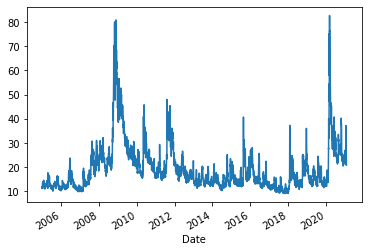

In [ ]:
vix = get_data(Symbols = ['^VIX'], start = datetime.datetime(2004,12,22), end = datetime.datetime(2021,2,8))
adj_prices_vix = vix[vix['Name'] == '^VIX']['Close']
adj_prices_vix.plot()
plt.show()

CO2 Data:

In [ ]:
"""
import urllib.request, json 
with urllib.request.urlopen("https://www.ncdc.noaa.gov/paleo-search/study/search.json?xmlId=19128") as url:
    data = json.loads(url.read().decode())
"""

In [ ]:
global_co2 = pd.read_csv("dataco2.csv")
x = np.array(global_co2['co2val'])
y = np.array(global_co2['age'])
co2 = pd.Series(x, index = y)

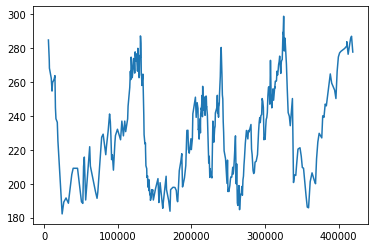

In [ ]:
co2.plot()

In [ ]:
co2.autocorr(lag = 10)

0.4789941699427743

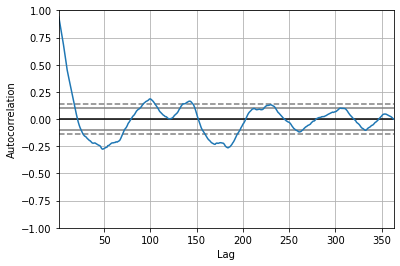

In [ ]:
pd.plotting.autocorrelation_plot(co2)

In [ ]:
pd.series